## Neural network playing ground (Small Methods Imgs)
### Nov 2023 - Code by Mauricio Cano Galván

Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import sys

sys.path.append("D:\personal_scripts")
from import_xyz_img import import_xyz_img
from conv_imgs import conv_imgs
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import cm, colormaps
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, concatenate
from keras.optimizers import Adam
from keras.utils import set_random_seed
from scipy.stats import norm
import seaborn as sns
import math
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from scipy import ndimage
from nn_backend.modified_loss_functions import cube_msle, linear_msle
from skimage import morphology
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import prediction_reconstruction_with_train, img_export, histogram_export
import fast.s26_analysis.utils as utils 
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:33, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

Scikit-optimize not installed. This is not essential since it is only used for the Hammersly scan pattern. We recommend using Halton, Sobol, or Latin hypercube instead.
Cannot find hdf5plugin and h5py packages. Cannot run the read_mda_h5_chunks_custom_roi function. Since this function has a very specific use case, this error can generally be ignored.


In [2]:
#Constant Setup
pctg=0.5


cutout_size=9

#Graphics (1 to show images, 0 to not)
kernel_visualization=0 
input_imgs_view=1
train_curve=0

#NN Setup
kernel_dim=3
iterations=300
batch_sz=200

#Other parameters
#topo_area_dim=9
use_last_curves=1

name='efm9'
curves_file=rf'd:\NN_Ep\pre_processed_curves\efm9_curves_calibrated.npy'
topography_file=rf'd:\rawData\Datos_Small_R_Mauricio\Datos_Small_R_Mauricio\EFM9\EFM9 Topography Flattened_nm.txt'
ref_file=rf"d:\rawData\Datos_Small_R_Mauricio\Datos_Small_R_Mauricio\EFM9\EFM9_full_ep_map_corrected.txt"
raw_curves_folder=0
curves_max_limit=1000
calibrate_curves=1
nu_dim=118
ref_flip=1

Data Import

In [3]:
#Curve import
if not raw_curves_folder:
    curves_projected=pd.DataFrame(np.load(rf'{curves_file}'))
    curves_projected=curves_projected.interpolate(axis=1)
    curves_projected=curves_projected.bfill(axis=1)
else:
    curves_projected, m_vec=import_curves_from_folder(curves_file)

    if calibrate_curves:
        K=0.718
        G=200
        uac=3
        curves_projected=curve_calibration(curves_projected, m_vec, K, G, uac)



In [4]:
#curves_name=rf'efm9_curves_calibrated'
#np.save('{curves_name}.npy', curves_projected)

In [5]:
#------Import the label data (εp map), as a matrix first and then transformed into a DataFrame.------#
#----------The data is then cleaned to remove outliers
y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
if ref_flip:
    y_mat=np.flipud(y_mat)
y_mat=matrix_cut(y_mat,nu_dim)
y=pd.DataFrame(np.reshape(y_mat,nu_dim**2))
#------Manual noise removal in label *ONLY FOR EFM9*------#

#Logarithmic sampling
maxlen=1713
curve_height_setpoint=20
curve_nsamples=12

zs=np.round((np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint)).astype(int)
samples = []
[samples.append(x) for x in zs if x not in samples]


#New curves
curves=(np.array(curves_projected)).reshape(128,128,len(curves_projected.iloc[0,:]))
curves=matrix_cut(curves, nu_dim)
curves_sampled=curves[:,:,samples]

#Topography import
T_mat, x, y2 = import_xyz_img(topography_file)
T_mat=matrix_cut(T_mat, nu_dim)
T_mat=np.expand_dims(T_mat, axis=2)
T=T_mat.reshape(nu_dim**2)
#Put together training dataset
X_mat=np.concatenate((T_mat, curves_sampled), axis=2)

aa=["Z = "+str(x)+" nm" for x in samples]
inputs=["Topography"]
inputs=np.append(inputs, aa)

X=np.reshape(X_mat,(nu_dim**2,len(X_mat[0,0,:])))
X=pd.DataFrame(X, columns=inputs)


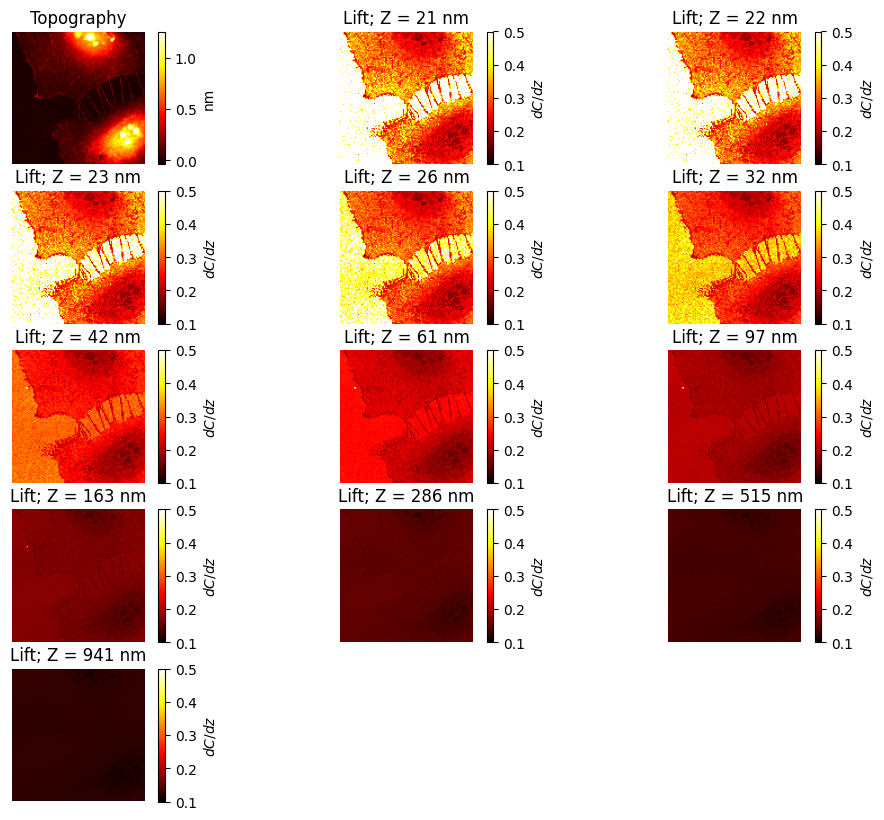

In [6]:
if input_imgs_view:
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(5,3,1)
    pcm=ax.imshow(X_mat[:,:,0], cmap='hot')
    ax.set_title("Topography")
    plt.colorbar(pcm, label="nm")
    ax.axis('off')
    for i in range(2,14):
        ax=fig.add_subplot(5,3,i)
        pcm=ax.imshow(X_mat[:,:,i-1], cmap='hot', vmin=0.1, vmax=0.5)
        h=samples[i-2]
        ax.set_title("Lift; Z = "+str(h)+" nm")
        plt.colorbar(pcm, label="$dC/dz$")
        ax.axis('off')
     

Data Pre-Processing

C:\Users\mcano\AppData\Local\Temp\ipykernel_14984\4064255435.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


Text(0.5, 1.0, 'Final Train Mask')

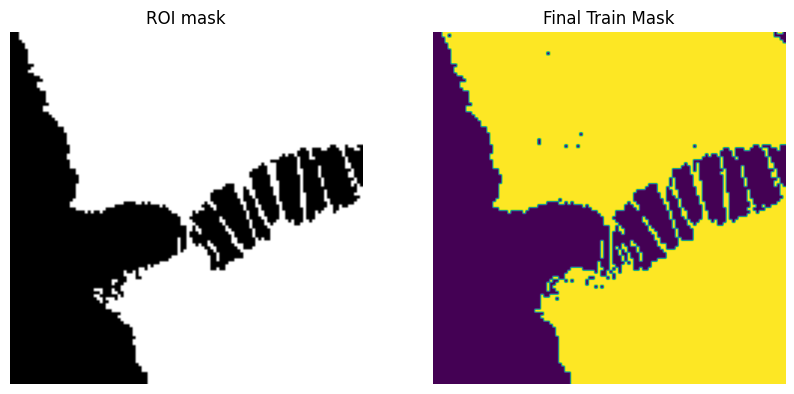

In [7]:
#EFM9: binary_threshold=0.01, object_size=3, hole_size=30, m_thresh=0.30
#EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
#EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
#EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785

binary_threshold=0.01
object_size=3
hole_size=30
m_ep_thresh=0.30

bin=mask_from_topo(T,binary_threshold,object_size,hole_size)

cell=bin.reshape(nu_dim**2,1)
roi_index=pd.DataFrame(copy(cell))
roi_index=roi_index.index[(roi_index[0])]


mask_ep=pd.DataFrame(copy(y))
th=float(mask_ep.quantile(m_ep_thresh))

mask_ep[(mask_ep[0]<=th)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))

cell_index=mask_ep.index[mask_ep[0]>0].tolist()


fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,2,1)
ax.imshow(bin, cmap='gray')
ax.set_title('ROI mask')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_ep_im)
ax.axis('off')
ax.set_title('Final Train Mask')


In [8]:
#------Cell separation------#
y_cell=pd.DataFrame(y.iloc[cell_index])
X_cell=pd.DataFrame(X.iloc[cell_index])
y_roi=pd.DataFrame(y.iloc[roi_index])
X_roi=pd.DataFrame(X.iloc[roi_index])


#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)
Xn_roi=pd.DataFrame(curve_scale.transform(X_roi), columns=inputs)

In [9]:

#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)

In [10]:

topo_mat, x, y2 = import_xyz_img(topography_file)
topo=topo_mat.reshape(len(topo_mat)**2,1)

topo_scale=StandardScaler()
topo_scale.fit(topo)
topo_n=topo_scale.transform(topo)
topo_n_mat=topo_n.reshape(len(topo_mat),len(topo_mat),1)

Cv_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size)
Cv_mat=Cv_mat.reshape(int(math.sqrt(len(Cv_mat))),int(math.sqrt(len(Cv_mat))),cutout_size,cutout_size)
Cv_mat=matrix_cut(Cv_mat, nu_dim)
Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
Cv_mat=np.expand_dims(Cv_mat, axis=-1)



Cv_cell_mat=Cv_mat[cell_index,:,:,:]
Cv_roi_mat=Cv_mat[roi_index,:,:,:]


Loading cutouts...:   0%|                          | 0/120 [00:00<?, ?it/s]

Loading cutouts...: 100%|████████████████| 120/120 [00:27<00:00,  4.44it/s]


Test-Train Separation

In [11]:

sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Xn_cell, y_cell)
train_index, test_index = next(sss.split(Xn_cell, y_cell))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Xn_cell.iloc[train_index], Xn_cell.iloc[test_index] 
y_train, y_test = y_cell.iloc[train_index], y_cell.iloc[test_index]

Cv_train, Cv_test = Cv_cell_mat[train_index,:,:], Cv_cell_mat[test_index,:,:] 
Cv_train_aug=data_augment(Cv_train)


N_aug=int(len(Cv_train_aug[:,0,0,0])/len(Cv_train[:,0,0,0]))

X_train_aug=copy(X_train)
y_train_aug=copy(y_train)
for i in np.arange(N_aug-1):
    X_train_aug=pd.DataFrame(np.concatenate((X_train_aug, X_train), axis=0))
    y_train_aug=pd.DataFrame(np.concatenate((y_train_aug, y_train), axis=0))

Network Architecture

In [13]:
#------Example Keras Network------#
reg, histo=nn_for_ep(X_train_aug,Cv_train_aug,y_train_aug,X_test,Cv_test,y_test, verb=0)

Results

C:\Users\mcano\AppData\Local\Temp\ipykernel_14984\1898807207.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_img[i]=y.iloc[i]


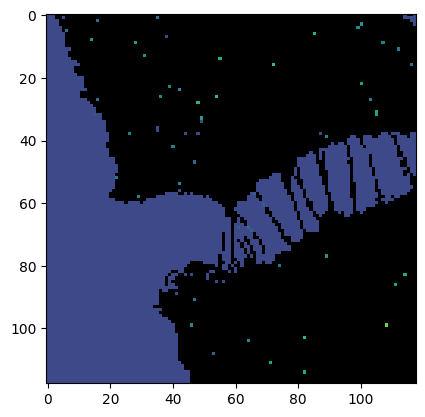

In [14]:
recon_nometal_index=(np.array(cell_index)[train_index])

no_cell=np.arange(nu_dim**2)
substrate=[]
[substrate.append(x) for x in no_cell if x not in cell_index]
recon_index=np.append(recon_nometal_index, substrate)


train_img=np.zeros(nu_dim**2)
for i in recon_index:
    train_img[i]=y.iloc[i]
train_img=train_img.reshape(nu_dim,nu_dim)
plt.imshow(train_img, vmin=-1, vmax=8, cmap=newcmp)

In [15]:
y_coord, x_coord= np.unravel_index(recon_index, (nu_dim, nu_dim))
init_pattern=np.column_stack((y_coord, x_coord))
erd_model_to_load = Path.cwd().parent / 'training/cameraman/c_2/erd_model_relu.pkl'
sample_fast = utils.create_experiment_sample(numx=y_mat.shape[1], numy=y_mat.shape[0],
                                        inner_batch_size=50,
                                        initial_idxs=init_pattern,
                                        erd_model_file_path=erd_model_to_load)

In [16]:
#res=reg.predict([Xn_roi, Cv_roi_mat])

In [17]:
from copy import deepcopy
import numpy as np
import numpy.typing as npt
from fast.input_params import ERDInputParams, GeneralInputParams, SampleParams
from fast.utils.img_loader import renormalize
from fast.core.data_structures import MeasurementInfo, NeighborsInfo
from fast.core.erd import ERDModel
from fast.core.measurement_interface import MeasurementInterface
from fast.core.neighbors import find_neighbors
from fast.core.recons import compute_recon
from fast.core.slads_features import compute_poly_features

In [18]:
# Actual simulation run. This can be fairly time consuming
masks_all = []
train_masks_all=[]
train_ratios_all=[]
recons_fast_all = []
ratios_all = []
tot_erds_all = []
count = 0
new_idxs = copy(init_pattern)

train_mask=np.zeros(nu_dim**2)
for i in recon_nometal_index:
    train_mask[i]=1
train_mask_still=copy(train_mask).reshape(nu_dim,nu_dim)
train_masks_all.append(train_mask_still)
train_ratio=train_mask_still.sum()/len(cell_index)
train_ratios_all.append(train_ratio.copy())



n_scan_points = int(0.05 * len(cell_index))
pbar = tqdm(total=n_scan_points, desc='Scanned points')
# Continue until we measure 40% of the points.
while train_mask_still.sum() < n_scan_points:
    # Supply the measurement values.
    sample_fast.measurement_interface.finalize_external_measurement(y_mat[new_idxs[:,0], new_idxs[:,1]])
    
    # Supply in measurement positions
    sample_fast.perform_measurements(new_idxs)
    




    
    # Use the measurement values to reconstruct the sample and calculate the ERDs
    #sample_fast.reconstruct_and_compute_erddd(mmm=1) ###Modify in fast\core\recons

        # Compute feature information for SLADS models; not needed for DLADS
    unmeasured_idxs = sample_fast._get_limited_update_locations(sample_fast.mask.copy(), deepcopy(sample_fast.measurement_info))

    measurement_info = deepcopy(sample_fast.measurement_info)
    measurement_info.unmeasured_idxs = unmeasured_idxs

    # Determine neighbor information for all unmeasured locations
    if len(sample_fast.measurement_info.unmeasured_idxs) > 0:
        sample_fast.neighbors = find_neighbors(measurement_info, sample_fast.params_gen.num_neighbors)
    else:
        sample_fast.neighbors = NeighborsInfo([], [], [], [])

    # Compute reconstructions, resize to physical dimensions
    res=reg.predict([Xn_roi, Cv_roi_mat], verbose=0)
    res=res.reshape(len(res))
    
    #VISUALIZACIÓN DE DATOS CALCULADOS
    full_vec_roi=np.zeros(nu_dim**2)+1
    for i in np.arange(len(roi_index)):
        full_vec_roi[roi_index[i]]=res[i]



    for i in y.index[np.array(cell_index)[train_index]]:
        full_vec_roi[i]=np.array(y).reshape(len(y))[i]


    full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))
        
    sample_fast.recon_image = copy(full_img_roi)
    

    if sample_fast.params_erd.model_type == "slads-net":
        sample_fast.poly_features = compute_poly_features(
            sample_fast.params_sample,
            sample_fast.recon_image,
            unmeasured_idxs,
            sample_fast.neighbors,
            sample_fast.params_erd.feat_distance_cutoff,
            sample_fast.params_erd.feature_type,
        )

    # Compute RD/ERD; if every location has been scanned all positions are zero
    # Determine the Estimated Reduction in Distortion

    if len(measurement_info.unmeasured_idxs) == 0:
        sample_fast.RD = np.zeros(sample_fast.params_sample.image_shape)
        sample_fast.ERD = np.zeros(sample_fast.params_sample.image_shape)
    else:
    # Compute the ERD with the prescribed model
        if sample_fast.params_erd.model_type == "slads-net":
            erds = sample_fast.erd_model.predict(sample_fast.poly_features)

        sample_fast.ERD[unmeasured_idxs[:, 0], unmeasured_idxs[:, 1]] = erds
        sample_fast.ERD = sample_fast._rescale_and_fix_erd(sample_fast.ERD, sample_fast.mask)
        sample_fast.iteration += 1





    # Compute new positions.

    new_idxs = sample_fast.find_new_measurement_idxs()[:1]
    
    
    new_idxs_vec = np.ravel_multi_index((new_idxs[:,0],new_idxs[:,1]),(nu_dim,nu_dim))
    
    new_idxs_vec_cell = []
    [new_idxs_vec_cell.append(x) for x in new_idxs_vec if x in cell_index] 
    
    y_coord, x_coord= np.unravel_index(np.array(new_idxs_vec_cell).astype(int), (nu_dim, nu_dim))
    provisional_idxs=np.column_stack((y_coord, x_coord))
    
    if len(provisional_idxs)>0:
        XNUn_new=pd.DataFrame(X.iloc[new_idxs_vec_cell])
        XNUn_new=pd.DataFrame(curve_scale.transform(XNUn_new), columns=inputs)
        
        Tn_conv_new=Cv_mat[new_idxs_vec_cell,:]
        ynu_new=pd.DataFrame(y.iloc[new_idxs_vec_cell])

        Tn_conv_new_aug=data_augment(Tn_conv_new)


        N_aug=int(len(Tn_conv_new_aug[:,0,0,0])/len(Tn_conv_new[:,0,0,0]))

        XNUn_new_aug=copy(XNUn_new)
        ynu_new_aug=copy(ynu_new)
        for i in np.arange(N_aug-1):
            XNUn_new_aug=pd.DataFrame(np.concatenate((XNUn_new_aug, XNUn_new), axis=0))
            ynu_new_aug=pd.DataFrame(np.concatenate((ynu_new_aug, ynu_new), axis=0))




        reg.fit([XNUn_new_aug,Tn_conv_new_aug],ynu_new_aug, verbose=0)
        new_idxs=copy(provisional_idxs)
        #print(rf"n train pixels = {len(new_idxs)}")
        for i in new_idxs_vec_cell:
            train_mask[i]=1
        train_mask_still=copy(train_mask).reshape(nu_dim,nu_dim)
    else:
        new_idxs=new_idxs[:10]
    train_ratio=train_mask_still.sum()/len(cell_index)
    train_ratios_all.append(train_ratio.copy())
    ratio = sample_fast.ratio_measured
    ratios_all.append(ratio)
    tot_erds_all.append(sample_fast.ERD.sum())
    recons_fast_all.append(sample_fast.recon_image.copy())
    masks_all.append(sample_fast.mask.copy())
    train_masks_all.append(train_mask_still.copy())
    pbar.update(int(train_mask_still.sum() - pbar.n))



    
res=reg.predict([Xn_roi, Cv_roi_mat])
res=res.reshape(len(res))
#VISUALIZACIÓN DE DATOS CALCULADOS
full_vec_roi=np.zeros(nu_dim**2)+1
for i in np.arange(len(roi_index)):
    full_vec_roi[roi_index[i]]=res[i]



for i in y.index[np.array(cell_index)[train_index]]:
    full_vec_roi[i]=np.array(y).reshape(len(y))[i]

full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))

recons_fast_all.append(full_img_roi.copy())

Scanned points:   0%|          | 0/458 [00:00<?, ?it/s]

0


Scanned points: 100%|██████████| 458/458 [06:55<00:00,  1.01s/it]

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\mcano\AppData\Local\Temp\ipykernel_14984\1208024721.py:160: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_roi[roi_index[i]]=res[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_14984\1208024721.py:165: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  full_vec_roi[i]=y.iloc[i]


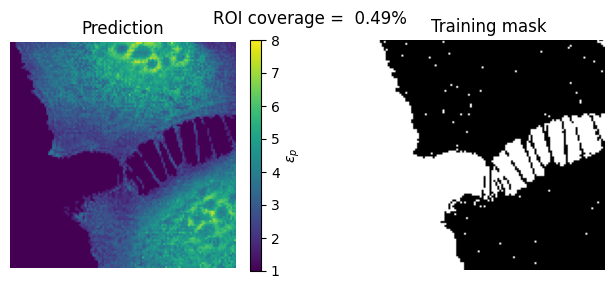

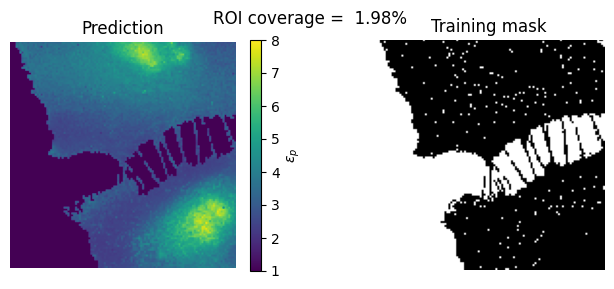

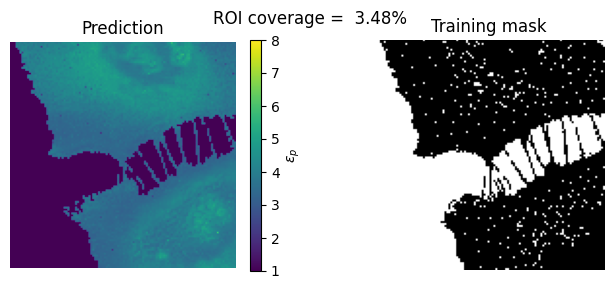

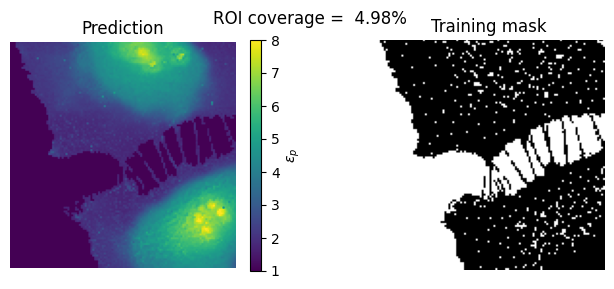

In [19]:
for ix in np.array(np.linspace(0, len(ratios_all)-1, 4)).astype(int):
    plt.figure(figsize=[8, 3])
    plt.subplot(1,2,1)
    plt.imshow(recons_fast_all[ix], vmin=1, vmax=8)
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(label="$ε_p$")
    plt.subplot(1,2,2)
    plt.imshow(masks_all[ix], cmap='gray')
    plt.axis('off')
    plt.title('Training mask')
    plt.suptitle(f'ROI coverage = {train_ratios_all[ix] * 100: 3.2f}%')
    plt.show()

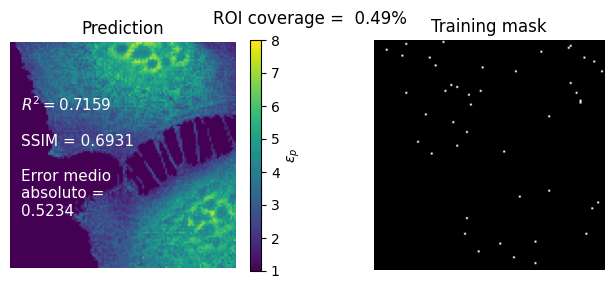

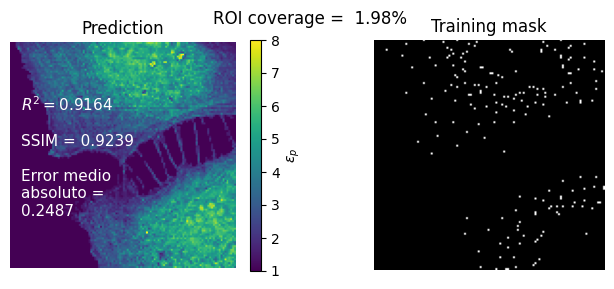

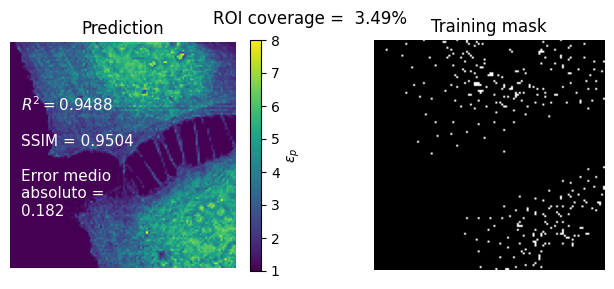

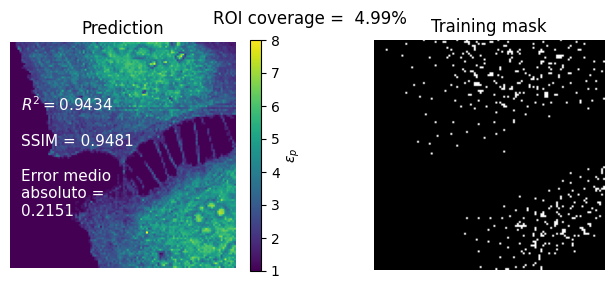

In [20]:
folder=rf'd:\Exports\pres240510'


for ix in np.array(np.linspace(0, len(train_ratios_all)-1, 4)).astype(int):
    smart_mask=pd.DataFrame(train_masks_all[ix].reshape(nu_dim**2))
    smart_mask=smart_mask.index[smart_mask[0]>0].tolist()
    XNUn_smart=pd.DataFrame(X.iloc[smart_mask])
    XNUn_smart=pd.DataFrame(curve_scale.transform(XNUn_smart), columns=inputs)

    Tn_conv_smart=Cv_mat[smart_mask,:]

    ynu_smart=pd.DataFrame(y.iloc[smart_mask])

    Tn_conv_smart_aug=data_augment(Tn_conv_smart)


    N_aug=int(len(Tn_conv_smart_aug[:,0,0,0])/len(Tn_conv_smart[:,0,0,0]))

    XNUn_smart_aug=copy(XNUn_smart)
    ynu_smart_aug=copy(ynu_smart)
    for i in np.arange(N_aug-1):
        XNUn_smart_aug=pd.DataFrame(np.concatenate((XNUn_smart_aug, XNUn_smart), axis=0))
        ynu_smart_aug=pd.DataFrame(np.concatenate((ynu_smart_aug, ynu_smart), axis=0))



    reg_smart, histo=nn_for_ep(XNUn_smart_aug,Tn_conv_smart_aug,ynu_smart_aug,X_test,Cv_test,y_test, verb=0)
    res_smart=reg_smart.predict([Xn_roi, Cv_roi_mat], verbose=0)
    res_smart=res_smart.reshape(len(res_smart))



    full_vec_roi=np.zeros(nu_dim**2)+1
    for i in np.arange(len(roi_index)):
        full_vec_roi[roi_index[i]]=res_smart[i]


    
    for i in y.index[np.array(cell_index)[train_index]]:
        full_vec_roi[i]=np.array(y).reshape(len(y))[i]

    full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))

    res_cell=np.array(full_vec_roi[cell_index])
    full_vec_cell=np.zeros(nu_dim**2)+1
    for i in np.arange(len(cell_index)):
        full_vec_cell[cell_index[i]]=res_cell[i]
    full_img_cell=np.reshape(full_vec_cell,(nu_dim,nu_dim))

    ssim_score = np.round(ssim(y_mat, full_img_cell, data_range=full_img_cell.max() - full_img_cell.min()), decimals=4)
    rsqr_cell=np.round(r2_score(y_cell, res_cell), decimals=4)
    mae_cell=mean_absolute_error(y_cell, res_cell)

    filename=rf'{name}_{int(train_ratios_all[ix] * 10000)}_pct_smart_drive'
    img_export(filename, folder, full_img_roi, full_vec_roi[cell_index], topography_file, nu_dim)
    histogram_export(full_vec_roi[cell_index], filename, folder)

    plt.figure(figsize=[8, 3])
    plt.subplot(1,2,1)
    plt.imshow(full_img_roi, vmin=1, vmax=8)
    plt.title('Prediction')
    plt.axis('off')
    plt.colorbar(label="$ε_p$")
    plt.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nSSIM = "+str(ssim_score)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#fff")

    plt.subplot(1,2,2)
    plt.imshow(train_masks_all[ix], cmap="gray")
    plt.axis('off')
    plt.title('Training mask')
    plt.suptitle(f'ROI coverage = {(train_ratios_all[ix] * 100): 3.2f}%')
    plt.show()